In [19]:
import numpy as np
from skimage.transform.radon_transform import _get_fourier_filter
from scipy.fft import fft, ifft, fftfreq, fftshift,ifftshift
from skimage.transform import radon, iradon
from skimage.draw import disk, rectangle
import matplotlib.pyplot as plt
from skimage.data import shepp_logan_phantom

> **_NOTE:_** function below is example code.

In [3]:
def ray(n, s, theta):
    """
    Trace ray:
        x(t) =  t*sin(theta) + s*cos(theta)
        y(t) = -t*cos(theta) + s*sin(theta)
    through volume [-1,1]^2, discretised with n x n pixels.
    
    Returns linear indices of intersected pixels and corresponding intersection lengths
    """
    
    # define boundaries of pixels
    h = 2/n
    x = -1 + np.linspace(0,n,n+1)*h
    y = -1 + np.linspace(0,n,n+1)*h
    
    # compute all intersections with horizontal and vertical grid lines
    # in terms of path length parameter t
    t = []
    if np.abs(np.sin(theta)) > 0:
        tx = (x - s*np.cos(theta))/np.sin(theta)
        t = np.concatenate((t,tx))
    if np.abs(np.cos(theta)) > 0 :
        ty = -(y - s*np.sin(theta))/np.cos(theta)
        t = np.concatenate((t,ty))
    
    # sort t in increasing order
    t = np.sort(t[np.isfinite(t)])
    
    # now trace the ray and store pixel-indices and path lengths
    nt = len(t)
    I = []
    w = []
    for i in range(nt-1):
        # entry point of ray
        x1 = t[i]*np.sin(theta) + s*np.cos(theta)
        y1 = -t[i]*np.cos(theta) + s*np.sin(theta)
        
        # exit point of ray
        x2 = t[i+1]*np.sin(theta) + s*np.cos(theta)
        y2 = -t[i+1]*np.cos(theta) + s*np.sin(theta)
        
        # pixel indices
        ix = int(((x1 + x2)/2+1)//h)
        iy = int(((y1 + y2)/2+1)//h)
        
        # only take pixels in volume [-1,1]^2 in to account
        if (0 <= ix < n) and (0 <= iy < n):
            I.append(int(iy*n + ix))
            w.append(t[i+1] - t[i])
        
    return I,w

> **_NOTE:_** function below is example code.

In [23]:
def Radon(u, n, s, theta):
    
    ns = len(s)
    nt = len(theta)
    # 
    f = np.zeros(ns*nt)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            f[i*ns + j] = np.array(w).dot(u[J])
    return f

def RadonTranspose(f, n, s, theta):
    
    ns = len(s)
    nt = len(theta)
    # 
    u = np.zeros(n*n)
    
    for i in range(nt):
        for j in range(ns):
            J,w = ray(n, s[j],theta[i])
            u[J] += np.array(w)*f[i*ns + j]
    return u

> **_NOTE:_** added Shepp-Logan filter to the example code.

In [5]:
def Filter(f, s, theta, option='ramp'):
    ns = len(s)
    nt = len(theta)
    ks = fftfreq(ns, s[1]-s[0])
    ks /= np.max(np.abs(ks))
    
    # filtered sinogram
    if option == 'ramp':
        filt = np.abs(ks).reshape((ns,1))
    elif option == 'cosine':
        filt = np.abs(ks * np.cos(np.pi*ks/2))
    elif option == "shepp_logan":
        filt = np.abs((2/np.pi) * np.sin(np.pi*ks/2))
    else:
        print('Filter option', option, 'not recognized, using no filter')
        filt = 1
    f_filter = np.real(ifft(filt * fft(f.reshape((nt,ns)).T, axis=0),axis=0)).T
    
    return f_filter.ravel()

> **_NOTE:_** slightly modified example code.

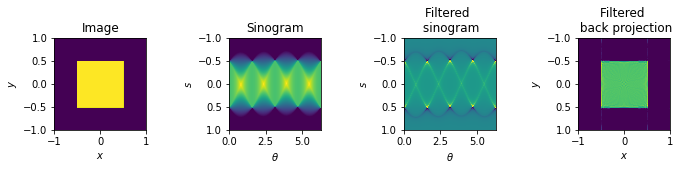

In [15]:
# Settings
nx = 100
theta = np.linspace(0., 2*np.pi, nx)
s = np.linspace(-1, 1, nx)

# Create the unit square
ii, jj = rectangle(start=(nx//4, nx//4), end=(3*nx//4, 3*nx//4))
u = np.zeros((nx, nx))
u[ii, jj] = 1

# Sinogram
f = Radon(u.ravel(), nx, s, theta)

# Filtered sinogram
f_filter = Filter(f, s, theta, "ramp")

# Filtered backprojection
u_fbp = RadonTranspose(f_filter, nx, s, theta)


# Plot
fig, ax = plt.subplots(1, 4)

ax[0].imshow(u,extent=(-1,1,-1,1),vmin=0)
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$y$")
ax[0].set_aspect(1)
ax[0].set_title("Image")

ax[1].imshow(f.reshape((nx,nx)).T, extent=(0, 2*np.pi, 1, -1), vmin=0)
ax[1].set_xlabel(r"$\theta$")
ax[1].set_ylabel(r"$s$")
ax[1].set_aspect(np.pi)
ax[1].set_title("Sinogram")

ax[2].imshow(f_filter.reshape((nx,nx)).T, extent=(0,2*np.pi, 1, -1), vmin=-.1, vmax=.1)
ax[2].set_xlabel(r"$\theta$")
ax[2].set_ylabel(r"$s$")
ax[2].set_aspect(np.pi)
ax[2].set_title("Filtered \n sinogram")

ax[3].imshow(u_fbp.reshape((nx,nx)),extent=(-1, 1, 1, -1), vmin=0)
ax[3].set_xlabel(r"$x$")
ax[3].set_ylabel(r"$y$")
ax[3].set_aspect(1)
ax[3].set_title("Filtered \n back projection")

fig.tight_layout()
fig.set_figwidth(10)

plt.savefig("./figures/lec4/filtered_back_projection.png", 
            dpi=300, transparent = True, bbox_inches = "tight", pad_inches = 0)

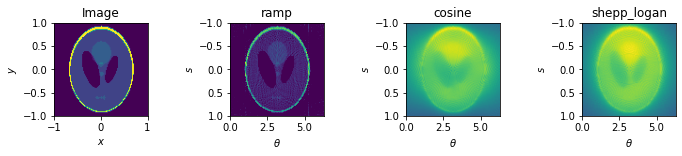

In [22]:
# Settings
nx = 100
theta = np.linspace(0., 2*np.pi, nx)
s = np.linspace(-1, 1, nx)

# Shepp-Logan phantom
u = shepp_logan_phantom()[::4, ::4]

# Sinogram
f = Radon(u.ravel(), nx, s, theta)


# Plot
fig, ax = plt.subplots(1, 4)

ax[0].imshow(u,extent=(-1,1,-1,1),vmin=0)
ax[0].set_xlabel(r"$x$")
ax[0].set_ylabel(r"$y$")
ax[0].set_aspect(1)
ax[0].set_title("Image")

filters = ["ramp", "cosine", "shepp_logan"]
for i in range(len(filters)):
    # Filtered sinogram
    f_filter = Filter(f, s, theta, filters[i])

    # Filtered back projection
    u_fbp = RadonTranspose(f_filter, nx, s, theta)
    
    ax[i+1].imshow(u_fbp.reshape((nx,nx)), extent=(0, 2*np.pi, 1, -1), vmin=0)
    ax[i+1].set_xlabel(r"$\theta$")
    ax[i+1].set_ylabel(r"$s$")
    ax[i+1].set_aspect(np.pi)
    ax[i+1].set_title(f"{filters[i]}")
    
fig.tight_layout()
fig.set_figwidth(10)

plt.savefig("./figures/lec4/multiple_filters.png", 
            dpi=300, transparent = True, bbox_inches = "tight", pad_inches = 0)